## Runs DE on different clusters. Also runs DE within each cluster for each condition.
Does this over each donor and combined

In [1]:
# Input info
se_f = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/SE.rds"
clone_changes_f = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/v2_MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/clone_change/filt_fisher__shuffle_False__padj_True__p_0.01_minC_1__bothMinC__1/clone_change.csv"

outdir = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/clone_change/filt_fisher__shuffle_False__padj_True__p_0.01_minC_1__bothMinC__1/de/sepClust/minPct_0.01__logfc0.1_pthresh_0.01/dev"
sample_names = "preB,postB"

# Parallel processing
cores = 4
# R utils script
utils_script <- "/data/Mito_Trace/R_scripts/seurat_utils.R"

top_de = 3
logfcthresh=0.1
minPct = 0.01
p_thresh=0.01

In [16]:
source(utils_script)
source("/data/Mito_Trace/R_scripts/plot_de_over_all.R")
dir.create(outdir)
donor.outdir <- file.path(outdir, "sepDonors")
dir.create(donor.outdir)

all.donor.outdir <- file.path(outdir, "allDonors")
dir.create(all.donor.outdir)

Warning message in dir.create(outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/clone_change/filt_fisher__shuffle_False__padj_True__p_0.01_minC_1__bothMinC__1/de/sepClust/minPct_0.01__logfc0.1_pthresh_0.01/dev' already exists"
Warning message in dir.create(donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/clone_change/filt_fisher__shuffle_False__padj_True__p_0.01_minC_1__bothMinC__1/de/sepClust/minPct_0.01__logfc0.1_pthresh_0.01/dev/sepDonors' already exists"


In [3]:
sample_names <- unlist(strsplit(sample_names, ",")[[1]])
sample_names

[1] "preB"  "postB"

In [4]:
library(GenomicRanges)
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)
set.seed(1234)
library(data.table)
library(magrittr)
library(cowplot)
library(metap)
library("RColorBrewer")
library(dplyr)
library(future)
plan()

plan("multiprocess", workers = cores)
#options(future.globals.maxSize = 50000 * 1024^2) # for 50 Gb RAM
options(future.globals.maxSize = 8000 * 1024^2)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:dplyr’:

    first, rename


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package:

sequential:
- args: function (..., envir = parent.frame())
- tweaked: FALSE
- call: NULL

Warning message:
"Strategy 'multiprocess' is deprecated in future (>= 1.20.0). Instead, explicitly specify either 'multisession' or 'multicore'. In the current R session, 'multiprocess' equals 'multicore'."


In [5]:
se <- readRDS(se_f)#file.path(indir, paste0("allSamples.integrated.rds")))
se

An object of class Seurat 
61893 features across 4112 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap

# Load clone_changes

In [6]:
clone_changes_f

[1] "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/v2_MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/clone_change/filt_fisher__shuffle_False__padj_True__p_0.01_minC_1__bothMinC__1/clone_change.csv"

In [7]:
clone_changes <- read.csv(clone_changes_f)
row.names(clone_changes) <-clone_changes$name

In [8]:
clone_changes[c("name","change")]

,name,change
,<chr>,<chr>
2_10,2_10,regress
3_5,3_5,expand
3_11,3_11,expand
3_1,3_1,no_change
1_23,1_23,no_change
1_13,1_13,no_change
3_12,3_12,no_change
3_13,3_13,no_change
0_32,0_32,no_change


## Subset clones

### Add change col metadata for each clone
a) subset se by clone names
b) need to map each cell based on the clone value, create a dataframe. should be same number rows as se

In [9]:
se.filt <- subset(se , subset = name %in% clone_changes$name)
se.filt = subset(se.filt , subset = (name != "None"))

In [10]:
meta <- se.filt[[]]
meta$change <- NA
for (cell in row.names(meta)){
    curr <- clone_changes[as.character(meta[cell, "name"]),"change"]
    if(is.na(curr)){
        break
    }
    meta[cell, "change"] = curr
}

se.filt <- AddMetaData(se.filt, meta[["change"]], col.name="change")


[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "regress"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "no_ch

In [11]:
clust.ids <- levels(se$seurat_clusters)
don.ids <- levels(se$donor)


Idents(se.filt) <- as.factor(apply(se.filt[[]][ , c("donor", "seurat_clusters", "change") ] , 1 , paste , collapse = "_" ))

# se.filt$change.stim <- paste(se.filt$change, se.filt$orig.ident, sep = "_")
# Idents(se.filt) <- "change"


#curr.ids <- levels(as.factor(apply(se[[]][ , c("seurat_clusters", "donor") ] , 1 , paste , collapse = "_" )))
#se$curr.id = Idents(se)

## a) For each donor, de for expanded vs regressed vs no change

[1] "donor 0"
[1] "Only one type of change for clone in this donor"
[1] "no_change"
[1] "Only one type of change for clone in this donor"
[1] "no_change"
[1] "Only one type of change for clone in this donor"
[1] "no_change"
[1] "Only one type of change for clone in this donor"
[1] "no_change"
[1] "Only one type of change for clone in this donor"
[1] "no_change"
[1] "Only one type of change for clone in this donor"
[1] "no_change"
[1] "Only one type of change for clone in this donor"
[1] "no_change"
[1] "Only one type of change for clone in this donor"
[1] "no_change"
[1] "Only one type of change for clone in this donor"
[1] "no_change"
[1] "Only one type of change for clone in this donor"
[1] "no_change"
[1] "Only one type of change for clone in this donor"
[1] "no_change"
[1] "donor 1"
[1] "Only one type of change for clone in this donor"
[1] "no_change"
[1] "Only one type of change for clone in this donor"
[1] "no_change"
[1] "Only one type of change for clone in this donor"
[1] "no_

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Saving 6.67 x 6.67 in image



[1] "se filt before"
[1] "se filt"
An object of class Seurat 
61893 features across 284 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                     p_val avg_log2FC pct.1 pct.2   p_val_adj p_val_adj_BH
PRG3          2.785441e-07 -0.3005983 0.000  0.10 0.005452501  0.001639789
CTD-2369P2.12 1.160693e-06 -0.1928188 0.015  0.20 0.022720561  0.003416499
SERPINB13     3.442697e-06 -0.1334024 0.008  0.15 0.067390790  0.006755719
[1] "dim response"
[1] 5887    6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "se filt before"
[1] "se filt"
An object of class Seurat 
61893 features across 237 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
TRIM60   1.379049e-09 -0.3187862 0.000 0.167 2.699488e-05 1.084208e-05
CTXN2    3.597043e-07 -0.2076123 0.005 0.167 7.041212e-03 1.279566e-03
THAP3    6.315710e-07 -0.2422854 0.014 0.222 1.236300e-02 1.279566e-03
DIRAS3   8.137662e-07 -0.1657117 0.000 0.111 1.592947e-02 1.279566e-03
FGF6     8.137662e-07 -0.2244455 0.000 0.111 1.592947e-02 1.279566e-03
C1orf198 1.225514e-06 -0.4695547 0.041 0.333 2.398943e-02 1.605831e-03
[1] "dim response"
[1] 7862    6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "se filt before"
[1] "se filt"
An object of class Seurat 
61893 features across 253 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 4849    6
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
61893 features across 176 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 6627    6
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
61893 features across 158 samples within 2 assays 
Active assay: RNA (19575 features, 0 va

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "se filt before"
[1] "se filt"
An object of class Seurat 
61893 features across 159 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                  p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
TUBB2B     2.376460e-08 -0.4127235 0.020 0.429 0.0004651921 0.0001826547
SPATA22    1.108584e-07 -0.3610008 0.007 0.286 0.0021700523 0.0002840191
CHAD       1.108584e-07 -0.1615034 0.007 0.286 0.0021700523 0.0002840191
LCK        2.760746e-06 -0.3261882 0.033 0.429 0.0540416093 0.0014849252
AC140481.2 3.670775e-06 -0.1456245 0.000 0.143 0.0718554279 0.0014849252
POTEE      3.670775e-06 -0.1195327 0.000 0.143 0.0718554279 0.0014849252
[1] "dim response"
[1] 7686    6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "se filt before"
[1] "se filt"
An object of class Seurat 
61893 features across 104 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
Error in ValidateCellGroups(object = object, cells.1 = cells.1, cells.2 = cells.2,  : 
  Cell group 2 has fewer than 3 cells
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
61893 features across 113 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
MSRB3   1.616277e-08 -0.7389867 0.094 0.857 0.0003163863 0.0001013049
UGT1A5  3.761788e-08 -0.2149601 0.000 0.286 0.0007363699 0.0001013049
SMCO2   3.761788e-08 -0.1986856 0.000 0.286 0.0007363699 0.0001013049
CREB3L3 2.411119e-07 -0.3346793 0.019 0.429 0.0047197661 0.0004869

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "se filt before"
[1] "se filt"
An object of class Seurat 
61893 features across 49 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 9304    6
[1] "Only one type of change for clone in this donor"
[1] "no_change"


The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Saving 6.67 x 6.67 in image

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two da

Warning message:
"Groups with fewer than two data points have been dropped."
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



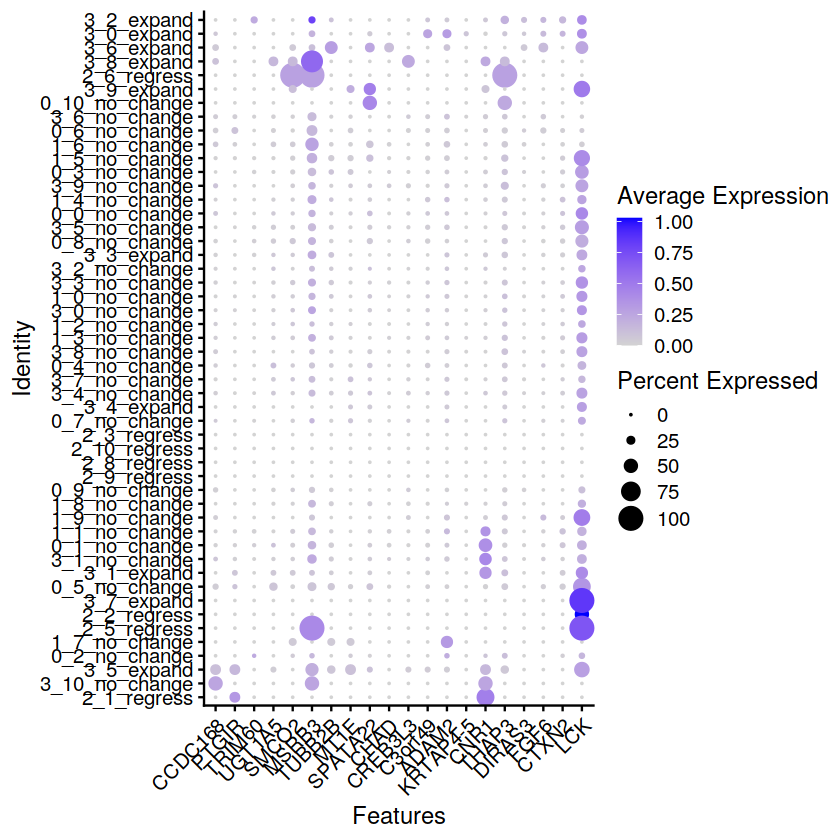

In [12]:
donors <- sort(unique(se.filt$donor))
all.pvals <- data.frame(matrix(nrow=dim(se.filt)[1],ncol=0),
                          row.names=row.names(se.filt))
all.names.sig <- c()
for (curr.donor in donors){
    print(paste0("donor ", curr.donor))
    for (curr.clust in clust.ids){
        try({
            curr.se <- subset(se.filt, subset = (donor == curr.donor) & (seurat_clusters==curr.clust))

            changes <- unique(curr.se$change)
            if (length(changes)<2){
                print("Only one type of change for clone in this donor")
                print(changes)
                next
            }
            pairs <- combn(changes, 2)
            for (p in 1:ncol(pairs)){
                pair <- pairs[,p]
                ident.1 = paste(curr.donor, curr.clust, pair[[1]] ,sep="_")
                ident.2 = paste(curr.donor, curr.clust, pair[[2]] ,sep="_")

                curr.name <- paste(ident.1, "vs", ident.2, "donor", curr.donor, "cluster", curr.clust, sep="_")
                #curr.dir <- paste0("donor", "_", curr.d)
                #curr.outdir <- file.path(donor.outdir, curr.dir)
                curr.outdir <- donor.outdir
                #dir.create(curr.outdir)

                ## Run DE
                curr.sig <- find.markers.and.plot(curr.se, ident.1, ident.2, curr.outdir, 
                                                  curr.name=curr.name, assay="RNA", logfcthresh=logfcthresh,
                                                  min.pct=minPct, p.thresh=p_thresh, mean.fxn=NULL, fc.name=NULL)
                #curr.sig <- run.de(p)

                # Add DE to global results
                names.sig <- rownames(curr.sig)
                all.names.sig <- c(all.names.sig, head(names.sig, top_de))
                all.pvals[names.sig,curr.name] <- curr.sig$p_val_adj_BH
            }
        })
    }
   
}

### a) top 3 significant results from each comparison
if (length(all.names.sig)>0){
    all.names.sig <- unique(all.names.sig)
    de.plots(se.filt, all.names.sig, donor.outdir, curr.name="allDonors.allClusters", max.size=15)

    dot <- DotPlot(se.filt, scale=FALSE,
                   features = head(all.names.sig,20), 
                   cluster.idents=T) + RotatedAxis()
    dot
    ggsave(file.path(donor.outdir, "allDonors.allClusters.top3de.png"))
    ggsave(file.path(donor.outdir, "allDonors.allClusters.top3de.pdf"))
    }


## b) averaged top p-values (only average ones that were DE)
try({
sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se.filt, scale=T,
               features = names(head(sig.all.ordered,20)), 
               cluster.idents=T) + RotatedAxis()
dot
ggsave(file.path(donor.outdir, "allDonors.allClusters.pvalsOrdered.png"))
ggsave(file.path(donor.outdir, "allDonors.allClusters.pvalsOrdered.pdf"))
#de.plots(se, names(sig.all.ordered), outdir, curr.name="allDonors.allClusters.pvalsOrdered", max.size=20)

sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se.filt, scale=F,
               features = head(names(sig.all.ordered),20), 
               cluster.idents=T) + RotatedAxis()
dot
    
})

## All donors

[1] "se filt before"
[1] "se filt"
An object of class Seurat 
61893 features across 691 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
MMP8     9.766613e-09 -0.1989051 0.005 0.107 0.0001911815 2.144048e-05
RAD51AP2 1.086192e-08 -0.1595802 0.005 0.107 0.0002126221 2.144048e-05
OR4K1    1.125288e-08 -0.1079810 0.005 0.107 0.0002202751 2.144048e-05
KRTAP4-5 3.539445e-08 -0.1109921 0.002 0.071 0.0006928464 5.054496e-05
C3orf49  4.421357e-08 -0.3099299 0.035 0.250 0.0008654807 5.054496e-05
PHLDA3   1.831530e-07 -0.2144409 0.006 0.107 0.0035852202 1.744838e-04
[1] "dim response"
[1] 5716    6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "se filt before"
[1] "se filt"
An object of class Seurat 
61893 features across 451 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
               p_val avg_log2FC pct.1 pct.2  p_val_adj p_val_adj_BH
KLF18   3.631541e-06 -0.1032625     0  0.05 0.07108741  0.006955611
MBD3L5  3.631541e-06 -0.1028708     0  0.05 0.07108741  0.006955611
LGALS16 3.631541e-06 -0.3554305     0  0.05 0.07108741  0.006955611
[1] "dim response"
[1] 5746    6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "se filt before"
[1] "se filt"
An object of class Seurat 
61893 features across 434 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
USP17L2 5.87573e-33 -0.2809107     0 0.333 1.150174e-28 9.396971e-30
OR1L1   5.87573e-33 -0.4719112     0 0.333 1.150174e-28 9.396971e-30
RASSF10 5.87573e-33 -2.3671492     0 0.333 1.150174e-28 9.396971e-30
COX8C   5.87573e-33 -0.2809107     0 0.333 1.150174e-28 9.396971e-30
GOLGA6B 5.87573e-33 -0.4719112     0 0.333 1.150174e-28 9.396971e-30
KRT37   5.87573e-33 -0.2809107     0 0.333 1.150174e-28 9.396971e-30
[1] "dim response"
[1] 11195     6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "se filt before"
[1] "se filt"
An object of class Seurat 
61893 features across 23 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 10858     6
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
61893 features across 383 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
Error in ValidateCellGroups(object = object, cells.1 = cells.1, cells.2 = cells.2,  : 
  Cell group 2 has fewer than 3 cells
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
61893 features across 421 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: 

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "se filt before"
[1] "se filt"
An object of class Seurat 
61893 features across 232 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
Error in ValidateCellGroups(object = object, cells.1 = cells.1, cells.2 = cells.2,  : 
  Cell group 2 has fewer than 3 cells
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
61893 features across 214 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                 p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
TUBB2B     1.52038e-09 -0.4146028 0.019 0.429 2.976143e-05 1.157617e-05
AC140481.2 6.24322e-08 -0.1456245 0.000 0.143 1.222110e-03 3.961323e-05
POTEE      6.24322e-08 -0.1195327 0.000 0.143 1.222110e-03 3.961323e-05
FAM205C    6.24322e-08 -0.1195327 0.000 0.143 1.222110e-03

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "se filt before"
[1] "se filt"
An object of class Seurat 
61893 features across 208 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
Error in ValidateCellGroups(object = object, cells.1 = cells.1, cells.2 = cells.2,  : 
  Cell group 2 has fewer than 3 cells
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
61893 features across 195 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
Error in ValidateCellGroups(object = object, cells.1 = cells.1, cells.2 = cells.2,  : 
  Cell group 2 has fewer than 3 cells
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
61893 features across 185 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: 

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "se filt before"
[1] "se filt"
An object of class Seurat 
61893 features across 179 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
Error in ValidateCellGroups(object = object, cells.1 = cells.1, cells.2 = cells.2,  : 
  Cell group 2 has fewer than 3 cells
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
61893 features across 92 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
TDRD15  3.693010e-09 -0.4264146 0.000   0.4 7.229067e-05 6.789968e-06
INHBB   3.693010e-09 -0.4656360 0.000   0.4 7.229067e-05 6.789968e-06
KBTBD12 3.693010e-09 -0.3899077 0.000   0.4 7.229067e-05 6.789968e-06
GNRHR   3.693010e-09 -0.2587690 0.000   0.4 7.229067e-05 6.789968e-

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "se filt before"
[1] "se filt"
An object of class Seurat 
61893 features across 88 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
Error in ValidateCellGroups(object = object, cells.1 = cells.1, cells.2 = cells.2,  : 
  Cell group 2 has fewer than 3 cells
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
61893 features across 5 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
Error in ValidateCellGroups(object = object, cells.1 = cells.1, cells.2 = cells.2,  : 
  Cell group 1 has fewer than 3 cells


The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Saving 6.67 x 6.67 in image

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two da

Warning message:
"Groups with fewer than two data points have been dropped."
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



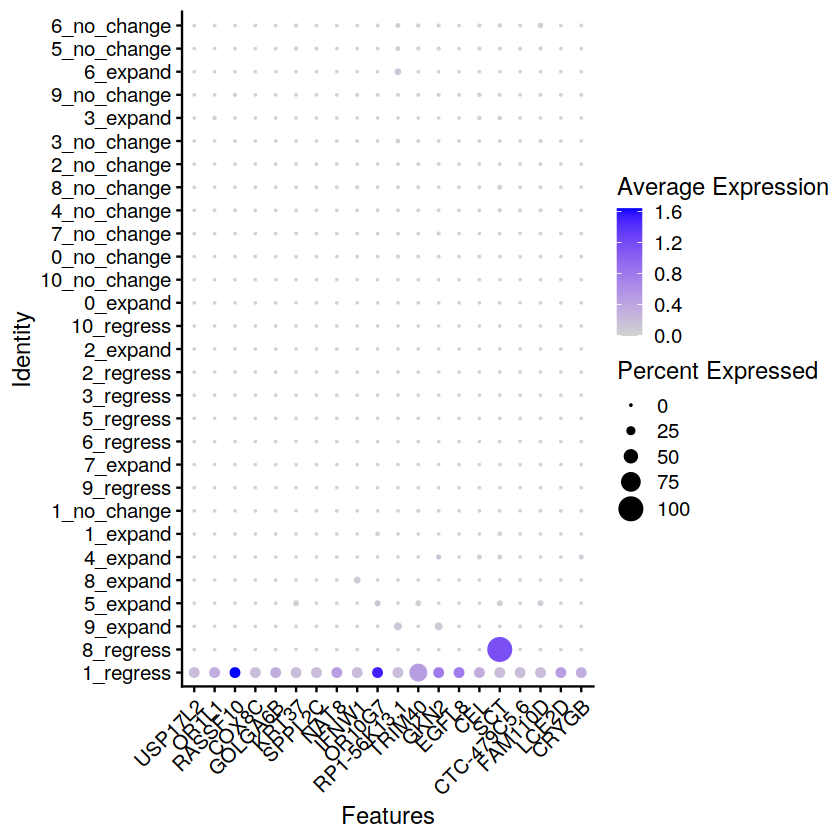

In [17]:
curr.outdir <- all.donor.outdir

Idents(se.filt) <- as.factor(apply(se.filt[[]][ , c("seurat_clusters", "change") ] , 1 , paste , collapse = "_" ))

all.pvals <- data.frame(matrix(nrow=dim(se.filt)[1],ncol=0),
                          row.names=row.names(se.filt))
all.names.sig <- c()

for (curr.clust in clust.ids){
    try({
        curr.se <- subset(se.filt, subset = (seurat_clusters==curr.clust))

        changes <- unique(curr.se$change)
        if (length(changes)<2){
            print("Only one type of change for clone in this donor")
            print(changes)
            next
        }
        pairs <- combn(changes, 2)
        for (p in 1:ncol(pairs)){
            pair <- pairs[,p]
            ident.1 = paste(curr.clust, pair[[1]] ,sep="_")
            ident.2 = paste(curr.clust, pair[[2]] ,sep="_")

            curr.name <- paste(ident.1, "vs", ident.2, "cluster", curr.clust, sep="_")
            #curr.dir <- paste0("donor", "_", curr.d)
            #curr.outdir <- file.path(donor.outdir, curr.dir)
            
            #dir.create(curr.outdir)

            ## Run DE
            curr.sig <- find.markers.and.plot(curr.se, ident.1, ident.2, curr.outdir, 
                                              curr.name=curr.name, assay="RNA", logfcthresh=logfcthresh,
                                              min.pct=minPct, p.thresh=p_thresh, mean.fxn=NULL, fc.name=NULL)
            #curr.sig <- run.de(p)
            # Add DE to global results
            names.sig <- rownames(curr.sig)
            all.names.sig <- c(all.names.sig, head(names.sig, top_de))
            all.pvals[names.sig,curr.name] <- curr.sig$p_val_adj_BH
        }
    })
}


### a) top 3 significant results from each comparison
if (length(all.names.sig)>0){
    all.names.sig <- unique(all.names.sig)
    de.plots(se.filt, all.names.sig, curr.outdir, curr.name="allDonors.allClusters", max.size=15)

    dot <- DotPlot(se.filt, scale=FALSE,
                   features = head(all.names.sig,20), 
                   cluster.idents=T) + RotatedAxis()
    dot
    ggsave(file.path(curr.outdir, "allDonors.allClusters.top3de.png"))
    ggsave(file.path(curr.outdir, "allDonors.allClusters.top3de.pdf"))
    }


## b) averaged top p-values (only average ones that were DE)
try({
sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se.filt, scale=T,
               features = names(head(sig.all.ordered,20)), 
               cluster.idents=T) + RotatedAxis()
dot
ggsave(file.path(curr.outdir, "allDonors.allClusters.pvalsOrdered.png"))
ggsave(file.path(curr.outdir, "allDonors.allClusters.pvalsOrdered.pdf"))
#de.plots(se, names(sig.all.ordered), outdir, curr.name="allDonors.allClusters.pvalsOrdered", max.size=20)

sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se.filt, scale=F,
               features = head(names(sig.all.ordered),20), 
               cluster.idents=T) + RotatedAxis()
dot
    
})

In [13]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.3 LTS

Matrix products: default
BLAS/LAPACK: /home/isaac/miniconda3/envs/mttrace/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] future_1.23.0             RColorBrewer_1.1-2       
 [3] metap_1.1                 cowplot_1.1.1            
 [5] magrittr_2.0.1            data.table_1.14.2        
 [7] patchwork_1.1.1           ggplot2_3.3.5            
 [9] EnsDb.Hsapiens.v75_2.99.0 ensembldb_2.18.1         
[11] 

In [14]:
outdir

[1] "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/clone_change/filt_fisher__shuffle_False__padj_True__p_0.01_minC_1__bothMinC__1/de/sepClust/minPct_0.01__logfc0.1_pthresh_0.01/dev"